# Model Predictive Control (MPC) 

Model predictive control (MPC) systems, as the name implies, use models to predict future glucose levels, and the control system makes desicions based on this. It is a mathematical approach to the artificial pancreas problem, where one aim to model the insulin-glucose dynamics {cite}`chee`. We can split MPC control systems into three parts: 
- A glucose prediction algorithm based on insulin-glucose dynamic models
- A control system unit to make optimal decisions based on future glucose level predictions
- Safety constraints on inputs, outputs and their rates of change {cite}`cinar`

For each time step, new predictions are made, and new decisions are made based on these predictions. Parameters of the insulin-glucose dynamics must be individually tuned. Also, there are several tunings to be made in the control system such as prediction horizon, correction horizon aggressiveness of corrections and glucose target area.  

## Glucose Prediction

In this section we will create a simple glucose prediction function, using the assumption that the only factor that has an impact on the BGC is the insulin, and that we know the basal rate that keeps glucose levels stable in the patient, as well as the insulin sensitivity factor (ISF) [mmol/L/U]. In this prediction we only consider one time step, and one insulin injection. In production this calculation must be made for every time step, 

The predicted BGC t minutes after the referenced BGC measurement can be expressed as

$
BG(t) = BG_{ref} - ISF * \sum_{i=1}^{\frac{t}{T}} (IOB(i*T) - IOB(i*T - T))
$

where T is the time interval between each BGC reading and insulin injection. $BG_{ref}$ is the referenced BGC, and IOB(t) is the calculated insulin on board t minutes after the referenced time. In this calculation we are assuming that the ISF and basal rate is constant. 

(mpc:iob)=
### Calculating insulin on board

To calculate insulin on board one must first decide on how to model insulin activity of an insulin injection. There are many studies on how to do this, and will also depend on the type of insulin injected. In reality the optimal insulin activity might vary from person to person, and might also vary throughout the lifetime of the patient. 

In this example we will use a linear model where we define the total time of insulin effect as well as peak insulin effect. 

In [68]:
# Static values: 
T = 5 # Measurement interval in minutes
ISF = 2 # Insulin sensitivity factor [mmol/L/U]
basal_rate = 1 # [U/hr]

total_activity = 3*60 # Total time of insulin effect in minutes
peak_activity = 75 # Time after insulin injection 
insulin_delay = 10 # Delay for insulin absorption to start

# Calculate the max value
max_val = 100*2/(total_activity - insulin_delay)

# Imports
import numpy as np
import matplotlib.pyplot as plt

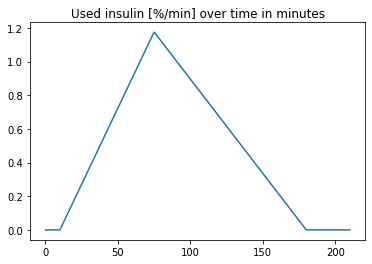

In [69]:
def calc_insulin_activity(t):
    # Returns the percentage of insulin used per minute t minutes after insulin injection
    
    if t < insulin_delay:
        return 0 
    elif (t < peak_activity):
        return t*(max_val)/(peak_activity - insulin_delay) - insulin_delay*max_val/(peak_activity - insulin_delay)
    elif (t < total_activity):
        return t*max_val/(peak_activity - total_activity) + total_activity*max_val/(total_activity - peak_activity)
    else: 
        return 0
    
# Plot insulin activity
x = np.linspace(0, 3*70, 300)
plt.plot(x, [calc_insulin_activity(item) for item in x] ) 
plt.title('Used insulin [%/min] over time in minutes') 
plt.draw() 
plt.show() 

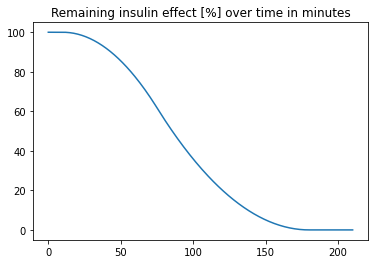

In [70]:
# Returns the percentage insulin effect remaining t minutes after insulin injection
def remaining_insulin_effect(t):
    
    if t < insulin_delay:
        return 100
    elif (t < peak_activity):
        return 100 - (t - insulin_delay)*(calc_insulin_activity(t))/2
    elif (t < total_activity):
        return 100 - max_val*(peak_activity - insulin_delay)/2 - (t - peak_activity)*(calc_insulin_activity(t) + (max_val-calc_insulin_activity(t))/2)
    else: 
        return 0
    
# Plot cumulative insulin effect
x = np.linspace(0, 3*70, 300)
plt.plot(x, [remaining_insulin_effect(item) for item in x] ) 
plt.title('Remaining insulin effect [%] over time in minutes') 
plt.draw() 
plt.show()     


### Predicting Future Glucose Levels Using Insulin on Board

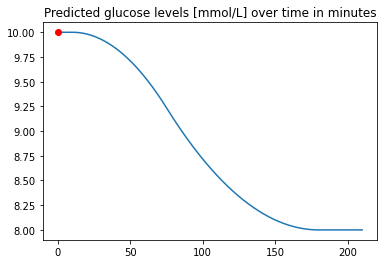

In [82]:
# Example where an insulin dose is injected in beginning (marked in plot as a red circle)

BG_ref = 10.0 
insulin_dose = 1
ISF = 2.0

# Calculate the predicted BGC given only one insuin dose given in the initial time
def predicted_BG(t): 
    return BG_ref - ISF*(100 - remaining_insulin_effect(t))*insulin_dose/100

# Plot cumulative insulin effect
x = np.linspace(0, 3*70, 300)
plt.plot(x, [predicted_BG(item) for item in x], 0, BG_ref, 'ro') 
plt.title('Predicted glucose levels [mmol/L] over time in minutes') 
plt.draw() 
plt.show()    


## Control System Unit

According to {cite}`cinar`, the control system unit usually works as following: A control horizon is defined, and has to be shorter or equal to the glucose prediction horizon. For each timestep, one calculate an optimal sequence of future control actions by minimizing an objective function. The optimal dose for the current timestep is injected, and then a new optimization is calculated for the next timestep. 

```{prf:algorithm} Minimize objective function
:label: obj_min

**Inputs** Given a vector with $insulin\_injections$ that impact future glucose levels, time interval $T$ between each timestep, number of timesteps $n$ in the prediction horizon, target BGC value $BG_{ref}$

**Output** Compute optimal insulin injection in the given timestep to minimize objective function 

1. $dose\_min\_error \leftarrow \inf$
2. For dose in range(0, max_insulin, insulin_increment):
    1. $insulin\_injections[-1] = dose$
    2. total_error = $\sum_{i=1}^{n} (BG\_prediction(i*T, insulin\_injections) - BG_{ref})^2$
    3. If ($total\_error < dose\_min\_error$):
        1. $dose\_min\_error \leftarrow total\_error$
3. return dose_min_error
```

One could add constraints to input and output values, as well as weight matrices to add more or less weight to differen time spans. In the algorithm above we have assumed control horizon with same length as prediction horizon. 

## Advantages and Disadvantages

### Advantages
An advantage of MPC is that it can be visually helpful for a patient to give insight into insulin-glucose dynamics. It is a simplification, which can also make it more understandable. It is also easy to manipulate, which can be an advantage when large deviations appear because of for example sickness. MPC is flexible in terms of adding complexities if the performance is not sufficient.

### Disadvantages
The main disadvantage with MPC control is the high level of inter- and intravariability. The human body is very complex and cannot easily be modeled from what we know today. A possibility is to include high degrees of freedom in the control systems, but this demands more effort and expertise from the users of the system. Another disadvantage are the factors that impact BGC but are not measurable with the available technology. An example is stress, which is then not simple to model and include in the model. 